In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import numpy as np
import seaborn as sns
import multiprocessing

2023-05-29 14:33:39.875918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-29 14:33:39.904123: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-29 14:33:39.904786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 14:33:40.774891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IOU_THRESHOLD = 0.5

LABEL_MAP = {
    "BENIGN": 0,
    "BENIGN_WITHOUT_CALLBACK": 0,
    "MALIGNANT": 1
}

In [3]:
test_df = pd.read_csv("../../dataset/preprocessed-datasets/preprocessed_metadata.csv").query("dataset == 'test'")
test_df.bounding_boxes = test_df.bounding_boxes.apply(json.loads)
test_df.head()

,Unnamed: 0,index,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,shape,margin,...,checksum,is_flipped,vertical_crop_pixels,horizontal_crop_pixels,width,height,preprocessed_original_image_path,num_masks,bounding_boxes,preprocessed_mass_all_mask_path
1231,1231,1318,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,...,01d92e6afdb23d4cb8c47957d1752468,True,400,1090,1090,3206,preprocessed/01d92e6afdb23d4cb8c47957d1752468.png,1,"[{'x': 160, 'y': 2188, 'width': 344, 'height':...",preprocessed/01d92e6afdb23d4cb8c47957d1752468_...
1232,1232,1319,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,...,7744b0030f652f04b7881e13b899ac8e,True,549,1153,1153,4393,preprocessed/7744b0030f652f04b7881e13b899ac8e.png,1,"[{'x': 99, 'y': 3110, 'width': 287, 'height': ...",preprocessed/7744b0030f652f04b7881e13b899ac8e_...
1233,1233,1320,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,...,e898aec727010780134e02a912f8ec0e,False,590,2654,2654,4724,preprocessed/e898aec727010780134e02a912f8ec0e.png,1,"[{'x': 251, 'y': 3177, 'width': 154, 'height':...",preprocessed/e898aec727010780134e02a912f8ec0e_...
1234,1234,1321,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,...,470b88f56461fe466cb064e56623c006,False,595,2650,2650,4762,preprocessed/470b88f56461fe466cb064e56623c006.png,1,"[{'x': 207, 'y': 3220, 'width': 184, 'height':...",preprocessed/470b88f56461fe466cb064e56623c006_...
1235,1235,1322,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,...,fc193735b1692e18ccf8d3e193fa545f,True,511,1935,1935,4094,preprocessed/fc193735b1692e18ccf8d3e193fa545f.png,1,"[{'x': 437, 'y': 1275, 'width': 335, 'height':...",preprocessed/fc193735b1692e18ccf8d3e193fa545f_...


In [4]:
def iou_coef(y_true, y_pred, smooth=0):
    y_true /= 0xff
    y_pred /= 0xff
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[0,1,2])
    union = tf.keras.backend.sum(y_true,[0,1,2])+tf.keras.backend.sum(y_pred,[0,1,2])-intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth))
    return iou

In [25]:
total_boxes = 0

for i, row in test_df.iterrows():
    total_boxes += len(row.bounding_boxes)

total_boxes

378

Total found regions: 7402
IOU threshold: 0.5, confidence threshold: 0.0
True regions: 397
Correctly found regions out of all regions: 1.0502645502645502
Correctly classified out of true regions: 0.6675062972292192
Correctly classified out of all regions: 0.701058201058201
False detections: 0.9641988651715753
[[  91 3954]
 [3183  174]]


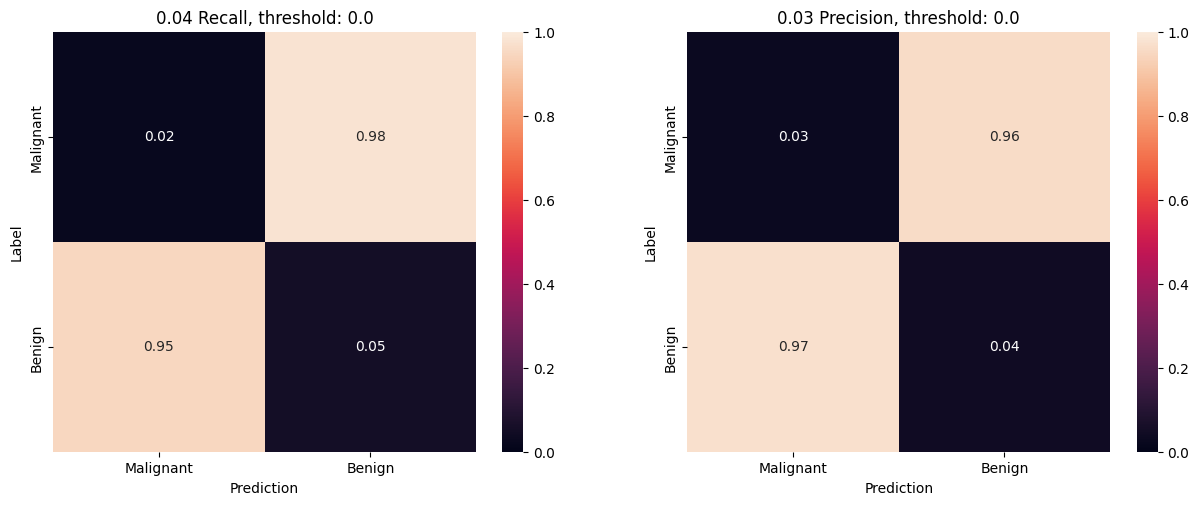

Total found regions: 2231
IOU threshold: 0.5, confidence threshold: 0.1
True regions: 316
Correctly found regions out of all regions: 0.8359788359788359
Correctly classified out of true regions: 0.7436708860759493
Correctly classified out of all regions: 0.6216931216931217
False detections: 0.894666069027342
[[  82 1077]
 [ 919  153]]


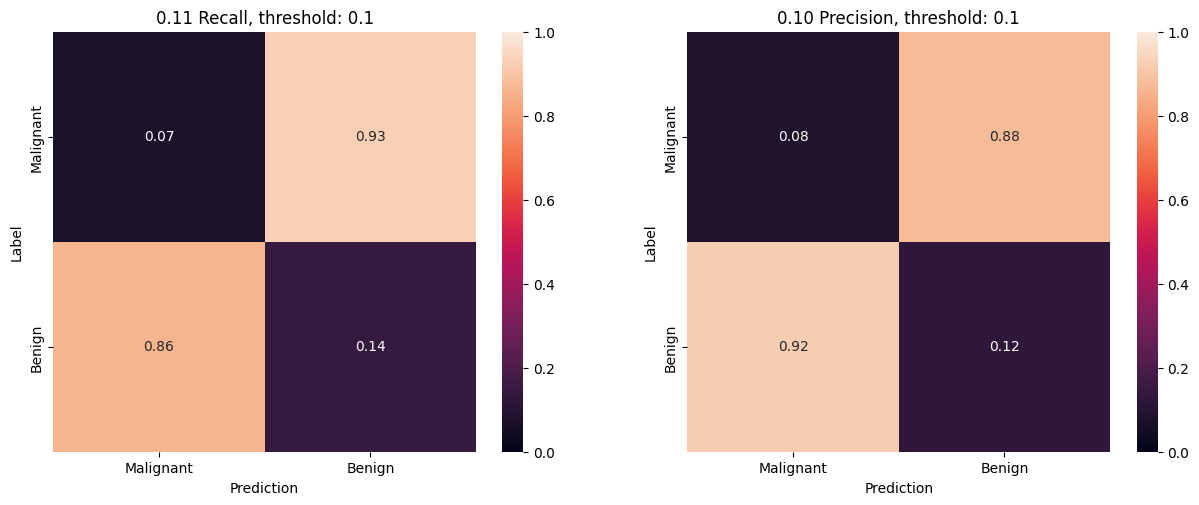

Total found regions: 698
IOU threshold: 0.5, confidence threshold: 0.2
True regions: 260
Correctly found regions out of all regions: 0.6878306878306878
Correctly classified out of true regions: 0.7846153846153846
Correctly classified out of all regions: 0.5396825396825397
False detections: 0.7077363896848138
[[ 79 269]
 [225 125]]


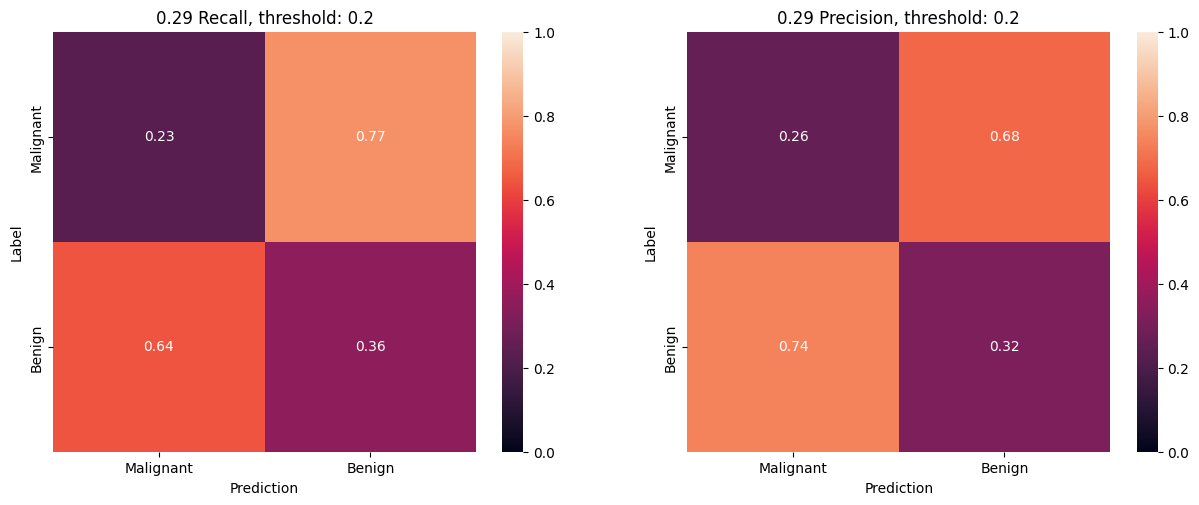

Total found regions: 374
IOU threshold: 0.5, confidence threshold: 0.3
True regions: 214
Correctly found regions out of all regions: 0.5661375661375662
Correctly classified out of true regions: 0.7757009345794392
Correctly classified out of all regions: 0.43915343915343913
False detections: 0.5561497326203209
[[ 69 112]
 [ 96  97]]


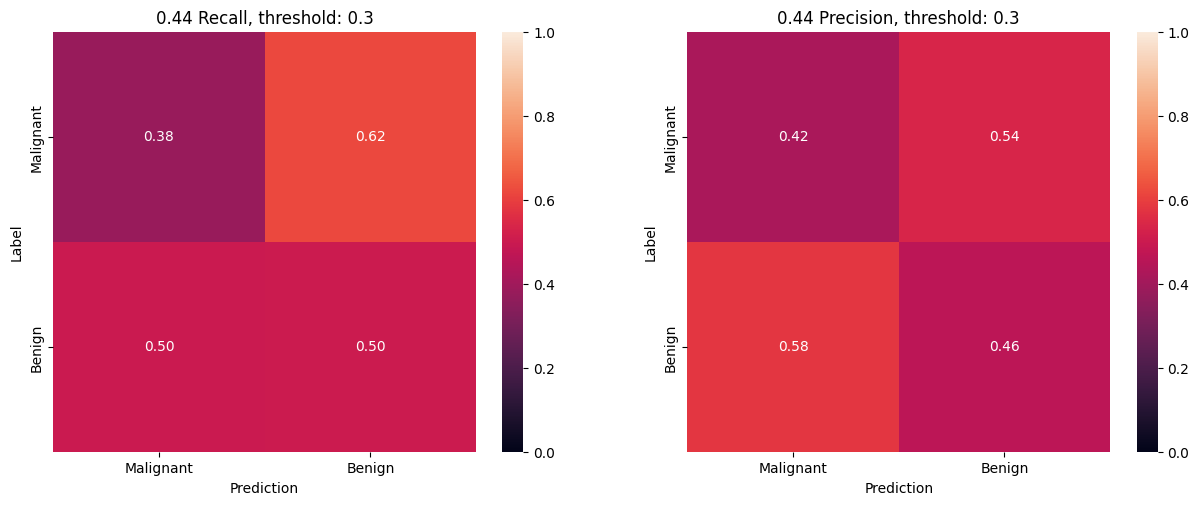

Total found regions: 228
IOU threshold: 0.5, confidence threshold: 0.4
True regions: 166
Correctly found regions out of all regions: 0.43915343915343913
Correctly classified out of true regions: 0.7831325301204819
Correctly classified out of all regions: 0.3439153439153439
False detections: 0.4298245614035088
[[60 52]
 [46 70]]


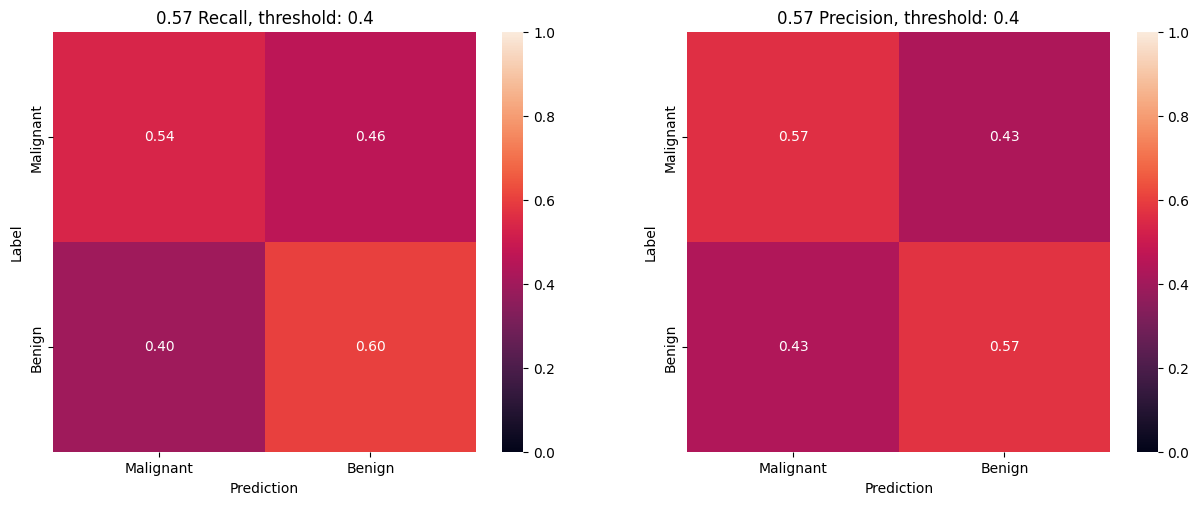

Total found regions: 112
IOU threshold: 0.5, confidence threshold: 0.5
True regions: 98
Correctly found regions out of all regions: 0.25925925925925924
Correctly classified out of true regions: 0.7653061224489796
Correctly classified out of all regions: 0.1984126984126984
False detections: 0.33035714285714285
[[40 15]
 [22 35]]


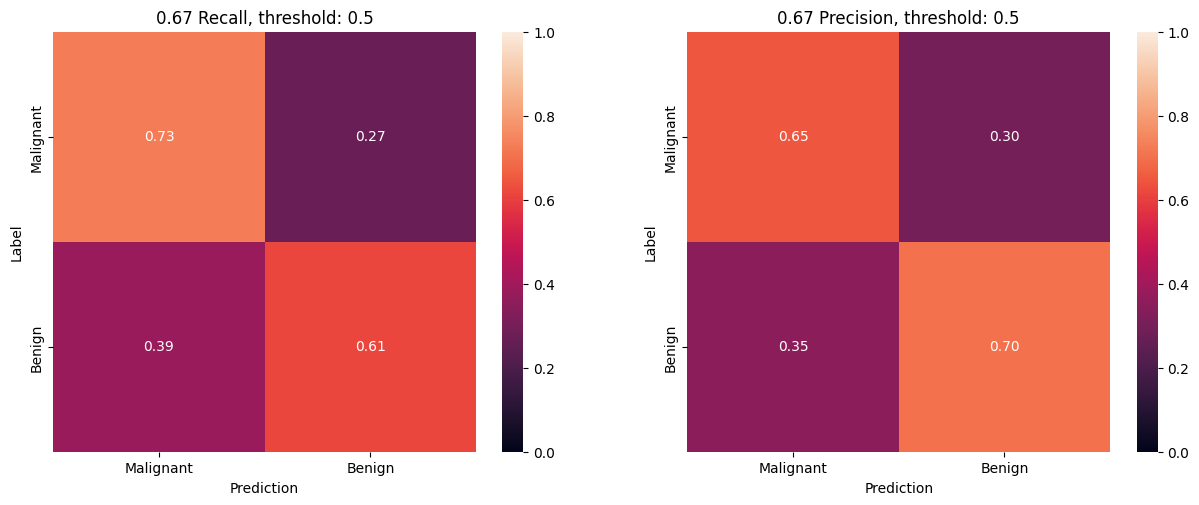

Total found regions: 31
IOU threshold: 0.5, confidence threshold: 0.6
True regions: 27
Correctly found regions out of all regions: 0.07142857142857142
Correctly classified out of true regions: 0.8148148148148148
Correctly classified out of all regions: 0.0582010582010582
False detections: 0.2903225806451613
[[14  3]
 [ 6  8]]


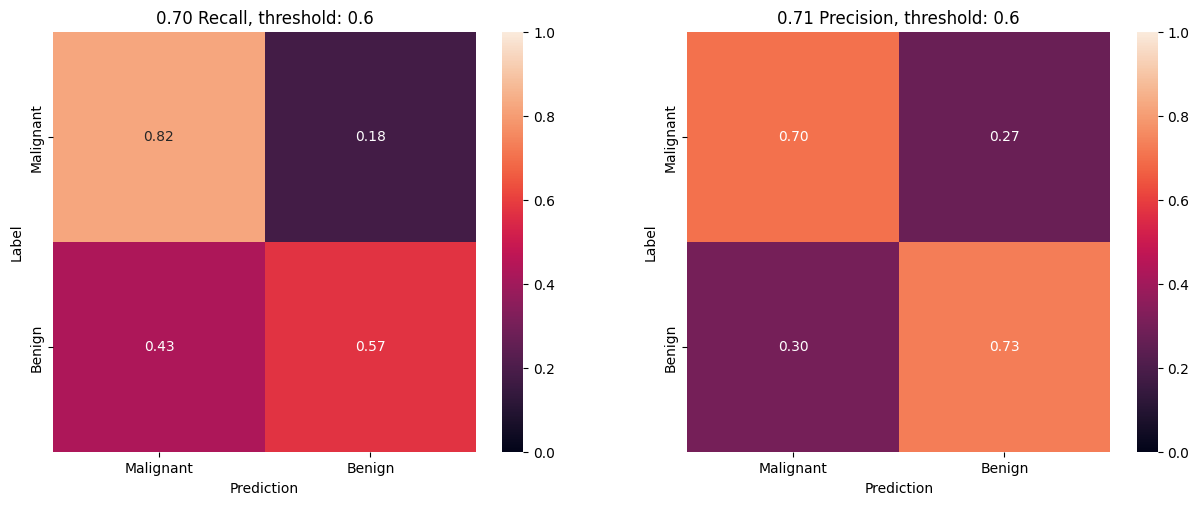

Total found regions: 4
IOU threshold: 0.5, confidence threshold: 0.7
True regions: 3
Correctly found regions out of all regions: 0.007936507936507936
Correctly classified out of true regions: 0.3333333333333333
Correctly classified out of all regions: 0.0026455026455026454
False detections: 0.75
[[1 1]
 [2 0]]


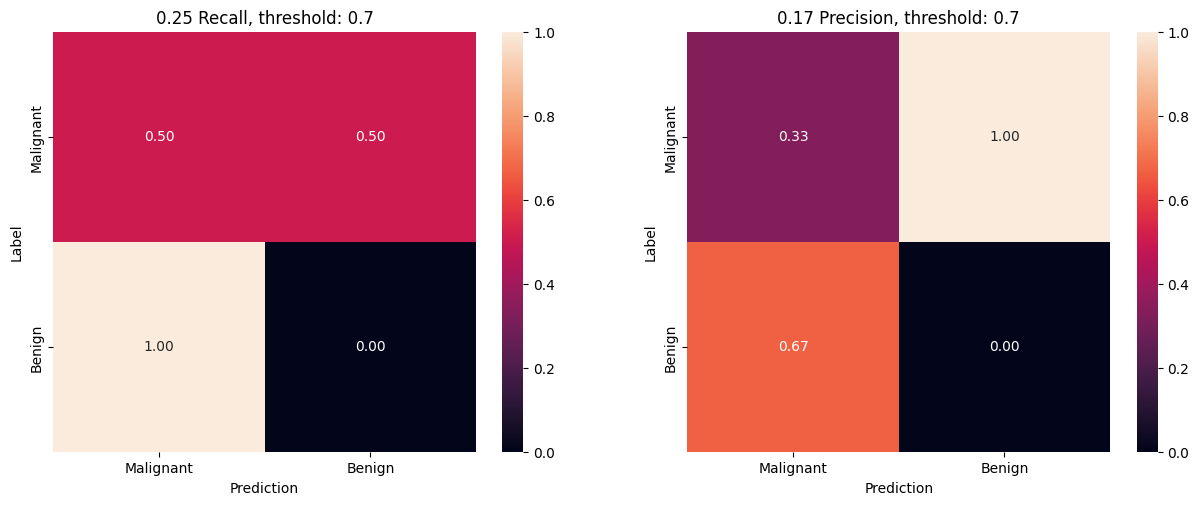

Total found regions: 1
IOU threshold: 0.5, confidence threshold: 0.8
True regions: 0
Correctly found regions out of all regions: 0.0


ZeroDivisionError: division by zero

In [27]:
def add_field_to_bbox(bbox):
    for box in bbox:
        box["matched"] = False
    return bbox


output_result = []

def run_analysis(region_threshold):
    results_df = pd.read_csv("../test/results_metadata_all.csv").query("bboxConfidence >= @region_threshold")

    results_df["predicted_label"] = results_df.pathology.apply(lambda x: round(x))
    num_detected_boxed = len(results_df)
    results_df.head()

    test_df.bounding_boxes = test_df.bounding_boxes.apply(add_field_to_bbox)

    true_predictions = []
    false_predictions = []

    true_regions = 0

    for i, result in results_df.iterrows():
        ground_truth = test_df.query("checksum == @result.checksum")
        result_image = tf.keras.utils.img_to_array(tf.keras.utils.load_img("../" + result.path))

        has_match = False

        for bbox in ground_truth.bounding_boxes.values[0]:
            if bbox["matched"] == True:
                continue

            gt_image = tf.keras.utils.img_to_array(tf.keras.utils.load_img("../../dataset/preprocessed-datasets/" + bbox["mask_path"]))
            iou = iou_coef(gt_image, result_image)
            
            true_label = LABEL_MAP[bbox["label"]]
            if iou > IOU_THRESHOLD:
                true_regions += 1
                if true_label == result.predicted_label:
                    true_predictions.append(true_label)
                    bbox["matched"] = True
                    has_match = True
                    break

        if not has_match:
            false_predictions.append(true_label)
        
    true_positives = np.count_nonzero(true_predictions)
    true_negatives = len(true_predictions) - true_positives
    false_positives = np.count_nonzero(false_predictions)
    false_negatives = len(false_predictions) - false_positives

    final_true_detections = (true_positives + true_negatives) / total_boxes
    final_false_detections = (num_detected_boxed - (true_positives + true_negatives)) / num_detected_boxed

    print(f"Total found regions: {num_detected_boxed}")
    print(f"IOU threshold: {IOU_THRESHOLD}, confidence threshold: {region_threshold}")
    print(f"True regions: {true_regions}")
    print(f"Correctly found regions out of all regions: {true_regions / total_boxes}")
    print(f"Correctly classified out of true regions: {(true_positives + true_negatives) / true_regions}")
    print(f"Correctly classified out of all regions: {final_true_detections}")
    print(f"False detections: {final_false_detections}")

    confusion_matrix = np.array([[true_positives, false_negatives], [false_positives, true_negatives]])

    output_result.append([
        num_detected_boxed, 
        region_threshold,
        true_regions,
        total_boxes,
        (true_positives + true_negatives),
        final_true_detections,
        final_false_detections,
        confusion_matrix
    ])
    
    print(confusion_matrix)

    classes = ["Malignant", "Benign"]

    def show_confusion_matrix(cm, labels, norm_axis, title):
        sum = cm.sum(axis=norm_axis)
        if norm_axis == 1:
            sum = sum[:, np.newaxis]
            
        cmn = cm.astype('float') / sum

        mean = (cmn[0][0] + cmn[1][1]) / 2
        sns.heatmap(
            cmn, 
            xticklabels=labels, 
            yticklabels=labels, 
            annot=True, 
            fmt='.2f',
            vmin=0.0,
            vmax=1.0,
        )
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title(f"{mean:.2f} {title}")

    plt.figure(figsize=(15, 12))
    plt.subplot(2, 2, 1)
    show_confusion_matrix(confusion_matrix, classes, 1, f'Recall, threshold: {region_threshold}')
    plt.subplot(2, 2, 2)
    show_confusion_matrix(confusion_matrix, classes, 0, f'Precision, threshold: {region_threshold}')
    plt.show()

for region_threshold in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    run_analysis(region_threshold)

In [29]:
output_df = pd.DataFrame(output_result, columns=[
    "num_detected_boxes", 
    "region_threshold",
    "true_regions", 
    "total_boxes", 
    "total_true_positives", 
    "final_true_detections", 
    "final_false_detections", 
    "confusion_matrix"
])

output_df.to_csv("./final_result.csv")

Text(0.5, 0, 'False positives')

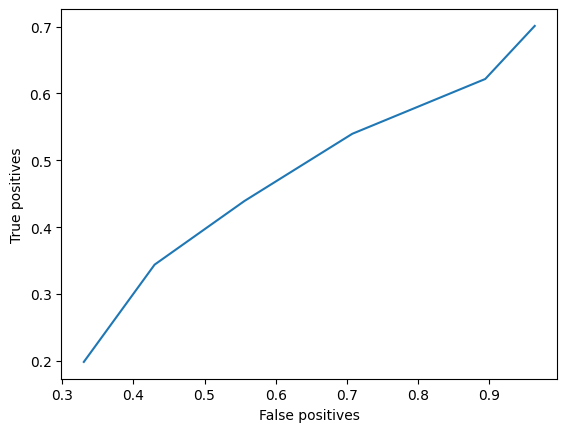

In [2]:
final_results = pd.read_csv("./final_result.csv").iloc[:-2]

plt.plot(final_results["final_false_detections"], final_results["final_true_detections"])
plt.ylabel("True positives")
plt.xlabel("False positives")